# DATA

## What is this notebook about

This notebook builds upon the notebook ``` spacenet6_masking.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget. 



This notebook shall be used for resizing all image input format. The available input formats will be
* PAN
* PS-RGB
* PS-RGBNIR
* RGBNIR
* SAR-Intensity

After resizing, these images will be saved to reduce the need for further processing. They will be saved in their original channel format, as a .tif file. The resized images will be read in and fed to a unet model to identify buildings. 

Functions to support data generation from all five image modes will be made available to easily generate the needed data

**Transfer learning**

This notebook is used to try and apply transfer learning to better enhance SAR data recognition

**Sample data**

To reduce time, sample data has been created by saving the image files as np arrays. Far less time is required to load these .npy files

## Setup COLAB and imports

Mount drive to gain access to files

In [ ]:
''' Used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Installations required

In [ ]:
! pip install rasterio
! pip install keras_unet
! pip install focal-loss
! pip install segmentation-models

     |████████████████████████████████| 18.2MB 1.2MB/s 


Imports required

In [ ]:
''' dealing with .tif files '''
import rasterio
from rasterio.plot import show, reshape_as_raster, reshape_as_image

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' core '''
import numpy as np
import pandas as pd

''' utilities '''
from tqdm import tqdm
import copy
import datetime

''' image processing '''
import tensorflow as tf
from tensorflow.keras.preprocessing import image

''' unet model '''
from keras import backend as K
from focal_loss import BinaryFocalLoss
from keras_unet.models import satellite_unet

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import JaccardLoss, BinaryFocalLoss
from segmentation_models.metrics import IOUScore, FScore

Using TensorFlow backend.


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Segmentation Models: using `keras` framework.


## Global

Constants and lookups - For reference the various image types are as such (amax is a rough gauge):

```
type             shape                dtype       gauge of max value    gauge of min value
PAN              (1, 900, 900)        uint16      1844                  0
PS-RGB           (3, 900, 900)        uint8       255                   0
PS-RGBNIR        (4, 900, 900)        uint16      2047                  0
RGBNIR           (4, 450, 450)        uint16      2047                  0
SAR-Intensity    (4, 900, 900)        float32     82.70110321044922     0.0
```



In [ ]:
''' get the same sequence for random set every time '''
seed = 42
np.random.seed = seed
tf.seed = seed       

''' lookup - define image channels for each image type '''
IMG_TYPE_LOOKUP = {
    'PAN': {'channels': 1, 'dtype': np.uint16}, 
    'PS-RGB': {'channels': 3, 'dtype': np.uint8}, 
    'PS-RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'SAR-Intensity': {'channels': 4, 'dtype': np.float32}, 
}

We will be setting the amount of data that we want to use for train/test
* There are 3401 images for each image type
* The actual spacenet6 "test folder" has only uneseen SAR-Intensity data

Therefore for training purposes, we will pull out our own "test data" from the training set for ease of verifying output 

Random indexes will be used for training and test

In [ ]:
''' set the various sizes we want to use '''
SIZE_ALL = 3401 
SIZE_TRAIN = 800           # CHANGE HERE
SIZE_TEST = 80            # CHANGE HERE


''' Generate the indexes that we will be using for train and test '''
ALL_IDX = np.arange(SIZE_ALL)

TRAIN_IDX = np.random.choice(ALL_IDX, SIZE_TRAIN, replace=False)
TRAIN_IDX.sort()

ALL_IDX_2 = np.setdiff1d(ALL_IDX, TRAIN_IDX)

TEST_IDX = np.random.choice(ALL_IDX_2, SIZE_TEST, replace=False)
TEST_IDX.sort()

## Helper functions

Available functions:
* ``` plot_XY(plotname: str, X: np.dtype[SIZE], Y: np.bool[SIZE], X_name: str, Y_name: str) : None ```
* ``` plot_XY_preds(plotname: str, X: np.dtype[SIZE], Y: np.bool[SIZE], P: np.bool[SIZE], X_name: str, Y_name: str, P_name: str) : None ```
* ``` recall_m(y_true, y_pred) : None ```
* ``` precision_m(y_true, y_pred) : None ```
* ``` f1_m(y_true, y_pred) : None ```

Various plotting functions

In [ ]:
def plot_XY(plotname, X, Y, X_name, Y_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  plt.show()

In [ ]:
def plot_XY_preds(plotname, X, Y, P, X_name, Y_name, P_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P[ix]), ax=ax3, title=P_name)
  plt.show()

In [ ]:
def plot_history(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

  ax1.plot(history['loss'], label='train')
  ax1.plot(history['val_loss'], label='val')
  ax1.title.set_text('loss')
  ax1.legend()

  ax2.plot(history['iou_score'], label='train')
  ax2.plot(history['val_iou_score'], label='val')
  ax2.title.set_text('iou_score')
  ax2.legend()

  ax3.plot(history['f1-score'], label='train')
  ax3.plot(history['val_f1-score'], label='val')
  ax3.title.set_text('f1-score')
  ax3.legend()

Define metrics for the unet models

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Create a csv file to store metrics history

In [ ]:
PATH_METRICS = '/content/gdrive/My Drive/Colab Notebooks/spacenet6/metrics_keras_8_9_10.csv'

# TIMESTAMP = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
# IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION = 'trial', 'trial', 'trial', 'trial'
# SIZE_TRAIN, SIZE_TEST, train_loss, train_iou_score, train_f1_score, val_loss, val_iou_score, val_f1_score, test_loss, test_iou_score, test_f1_score = 0,0,0,0,0,0,0,0,0,0,0

# METRICS_HISTORY = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, 
#                              train_loss, train_iou_score, train_f1_score, 
#                              val_loss, val_iou_score, val_f1_score, 
#                              test_loss, test_iou_score, test_f1_score
#                              ]]),
#                    columns=['timestamp', 'img_type', 'model_type', 'pretrain', 'loss_function', 'size_train', 'size_test', 
#                             'train_loss', 'train_iou_score', 'train_f1-score', 
#                             'val_loss', 'val_iou_score', 'val_f1-score', 
#                             'test_loss', 'test_iou_score', 'test_f1-score'
#                             ],
#                   )
# METRICS_HISTORY.to_csv(PATH_METRICS, index=False)



In [ ]:
def store_metrics(train_loss, train_iou_score, train_f1_score, val_loss, val_iou_score, val_f1_score, test_loss, test_iou_score, test_f1_score, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS):
  TIMESTAMP = datetime.datetime.now().strftime("%m/%d/%Y %H:%M:%S")

  ''' create another df that looks just like that and concat with ''' 
  new_metrics = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, 
                             train_loss, train_iou_score, train_f1_score, 
                             val_loss, val_iou_score, val_f1_score, 
                             test_loss, test_iou_score, test_f1_score
                             ]]),
                   columns=['timestamp', 'img_type', 'model_type', 'pretrain', 'loss_function', 'size_train', 'size_test', 
                            'train_loss', 'train_iou_score', 'train_f1-score', 
                            'val_loss', 'val_iou_score', 'val_f1-score', 
                            'test_loss', 'test_iou_score', 'test_f1-score'
                            ],
                  )
  
  METRICS_HISTORY = pd.read_csv(PATH_METRICS)
  METRICS_HISTORY = pd.concat([new_metrics, METRICS_HISTORY])
  METRICS_HISTORY.to_csv(PATH_METRICS, index=False)
  print("saved model metrics")


## Generator

Available generators: 

* ``` gen_input_image_details(IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP) : (IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_CHANNELS: int64, IMG_DTYPE_SRC: np.dtype, IMG_DTYPE: np.uint8) ```

* ``` gen_paths(IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64) : (PATH_SRC: PosixPath, PATH_SRC_IMAGE: PosixPath, PATH_SRC_MASK: PosixPath, PATH_DATA: PosixPath, PATH_IMAGE: PosixPath, PATH_MASK: PosixPath) ```

* ``` gen_resized_images(PATH_SRC_IMAGE: PosixPath, PATH_SRC_MASK: PosixPath, PATH_IMAGE: PosixPath, PATH_MASK: PosixPath, IMG_HEIGHT: int64, IMG_WIDTH: int64) : None ```

* ``` gen_train_test_set(PATH_IMAGE: PosixPath, PATH_MASK: PosixPath, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_CHANNELS: int64, IMG_DTYPE_SRC: np.dtype, TRAIN_IDX: int64[SIZE_TRAIN], TEST_IDX: int64[SIZE_TEST]) : (X_train: np.dtype[SIZE_TRAIN], Y_train: np.bool[SIZE_TRAIN], X_test: np.dtype[SIZE_TEST], Y_test: np.bool[SIZE_TEST]) ```

Reading several papers has indicated that 256x256 size is a good size for the model, hence we shall use it as the image size for now. We will set the output specifications here

In [ ]:
def gen_input_image_details(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP):
  IMG_CHANNELS = IMG_TYPE_LOOKUP[IMG_TYPE]['channels']
  IMG_DTYPE_SRC = IMG_TYPE_LOOKUP[IMG_TYPE]['dtype']
  IMG_DTYPE = np.uint8               

  return (IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE)

Setting the paths that we require, which will change based on the image type and image size specified

In [ ]:
def gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH):
  ''' set the original data source folder '''
  PATH_SRC = Path(root_dir + '/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam')
  PATH_SRC_IMAGE = PATH_SRC/IMG_TYPE
  PATH_SRC_MASK = PATH_SRC/'_mask'


  ''' change in accordance to the image type and dimensions '''
  COMBI = IMG_TYPE + '_' + str(IMG_HEIGHT) + 'x' + str(IMG_WIDTH)


  ''' set the directories for this combination '''
  PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data/' + COMBI)
  PATH_DATA.mkdir(parents=True, exist_ok=True)

  PATH_IMAGE = PATH_DATA/'image'
  PATH_IMAGE.mkdir(parents=True, exist_ok=True)

  PATH_MASK = PATH_DATA/'mask'
  PATH_MASK.mkdir(parents=True, exist_ok=True)

  return (PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK)

This will check if the required resized images have already been created. If not, it will create it.

In [ ]:
def gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH):
  def resize_and_save(img_src_path, img_fname, img_save_path):
    img = rasterio.open(img_src_path/img_fname)

    ''' use the metadata from the original image '''
    transform = img.transform
    meta = img.meta.copy()

    ''' resize the image '''
    resized_img = img.read()
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))
    resized_img = reshape_as_image(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    resized_img = tf.image.resize(resized_img, [IMG_HEIGHT, IMG_WIDTH], method='nearest', preserve_aspect_ratio=True, antialias=True)
    resized_img = reshape_as_raster(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    ''' update metadata with new size '''
    meta.update({"transform": transform,
                "height": resized_img.shape[1],
                "width": resized_img.shape[2]
                })

    ''' write the resized image to a new geotiff '''
    with rasterio.open(img_save_path/img_fname, 'w', **meta) as dst:
      dst.write(resized_img)




  ''' Verify contents in source directory are present and assign to iterator '''
  src_image_ids = next(os.walk(PATH_SRC_IMAGE))[2]
  src_image_ids.sort()
  # print('len(src_image_ids): {}'.format(len(src_image_ids)))
  # print(src_image_ids[:3])

  src_mask_ids = next(os.walk(PATH_SRC_MASK))[2]
  src_mask_ids.sort()
  # print('len(src_mask_ids): {}'.format(len(src_mask_ids)))
  # print(src_mask_ids[:3])


  ''' check the target directory for existing files '''
  existing_image_ids = next(os.walk(PATH_IMAGE))[2]
  existing_image_ids.sort()
  # print('len(existing_image_ids): {}'.format(len(existing_image_ids)))
  # print(existing_image_ids[:3])

  existing_mask_ids = next(os.walk(PATH_MASK))[2]
  existing_mask_ids.sort()
  # print('len(existing_mask_ids): {}'.format(len(existing_mask_ids)))
  # print(existing_mask_ids[:3])


  ''' check if resized files already exist, else create them '''
  if (existing_image_ids == src_image_ids) and (existing_mask_ids == src_mask_ids): 
    print('Resized images and masks available')
    pass
  else:
    # print('Resizing image')
    for n, id in tqdm(enumerate(src_image_ids), total=len(src_image_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_IMAGE, id, PATH_IMAGE)
    # print('Finished resizing image')

    # print('Resizing mask')
    for n, id in tqdm(enumerate(src_mask_ids), total=len(src_mask_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_MASK, id, PATH_MASK)
    # print('Finished resizing mask')

    print('Resized images and masks generated')

This will return the train test set 

In [ ]:
def gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX):
  ''' get the ids/filenames that we need, based on the random index allocation to avoid grouping '''
  ''' X are image files, Y are mask files '''
  all_img_ids = next(os.walk(PATH_IMAGE))[2]
  all_img_ids.sort()
  all_img_ids = np.array(all_img_ids)

  all_mask_ids = next(os.walk(PATH_MASK))[2]
  all_mask_ids.sort()
  all_mask_ids = np.array(all_mask_ids)

  X_train_ids = all_img_ids[TRAIN_IDX]
  X_train_ids.sort()
  Y_train_ids = all_mask_ids[TRAIN_IDX]
  Y_train_ids.sort()

  X_test_ids = all_img_ids[TEST_IDX]
  X_test_ids.sort()
  Y_test_ids = all_mask_ids[TEST_IDX]
  Y_test_ids.sort()

  # print(len(all_img_ids))
  # print(all_img_ids[:3])
  # print(len(all_mask_ids))
  # print(all_mask_ids[:3])
  # print(len(X_train_ids))
  # print(X_train_ids[:3])
  # print(len(Y_train_ids))
  # print(Y_train_ids[:3])
  # print(len(X_test_ids))
  # print(X_test_ids[:3])
  # print(len(Y_test_ids))
  # print(Y_test_ids[:3])


  ''' prepare numpy arrays to store converted image and mask files. Image files will need to be converted to IMG_DTYPE_SRC and mask files will be converted to np.bool '''
  X_train = np.zeros((len(X_train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
  Y_train = np.zeros((len(Y_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
  Y_test = np.zeros((len(Y_test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

  # print('X_train', X_train.shape, X_train.dtype)
  # print('Y_train', Y_train.shape, Y_train.dtype)
  # print('X_test', X_test.shape, X_test.dtype)
  # print('Y_test', Y_test.shape, Y_test.dtype)

  ''' actually format the imaegs into the correct data shape and type '''
  print('formatting training images')
  for n, id in tqdm(enumerate(X_train_ids), total=len(X_train_ids), position=0, leave=True):
    img = rasterio.open(PATH_IMAGE/id).read()
    img = reshape_as_image(img)
    X_train[n] = img
  print('Finished formatting training images')

  print('formatting training masks')
  for n, id in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids), position=0, leave=True):
    img = rasterio.open(PATH_MASK/id).read()
    img = reshape_as_image(img)
    img = img.astype(np.bool) 
    Y_train[n] = img
  print('Finished formatting training masks')

  print('formatting test images')
  for n, id in tqdm(enumerate(X_test_ids), total=len(X_test_ids), position=0, leave=True):
    img = rasterio.open(PATH_IMAGE/id).read()
    img = reshape_as_image(img)
    X_test[n] = img
  print('Finished formatting test images')

  print('formatting test masks')
  for n, id in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids), position=0, leave=True):
    img = rasterio.open(PATH_MASK/id).read()
    img = reshape_as_image(img)
    img = img.astype(np.bool) 
    Y_test[n] = img
  print('Finished formatting test masks')  


  return (X_train, Y_train, X_test, Y_test)

This will modify the SAR data to something that can be accepted by the unet without crashing

In [ ]:
def gen_modified_sar(X_train_sar, X_test_sar, SIZE_TRAIN, SIZE_TEST):
  ''' Convert the float32 to uint8 '''
  if np.amax(X_train_sar) > np.amax(X_test_sar):
    sar_max = np.amax(X_train_sar)
  else:
    sar_max = np.amax(X_test_sar)

  X_train_sar *= 255.0/sar_max
  X_test_sar *= 255.0/sar_max

  X_train_sar = X_train_sar.astype(np.uint8)
  X_test_sar = X_test_sar.astype(np.uint8)

  return (X_train_sar, X_test_sar)

In [ ]:
def gen_basic_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, X_train, Y_train, MODEL_VAL_SPLIT, MODEL_BATCH_SIZE, MODEL_EPOCHS, PATH_DATA, MODEL_NAME):
  model = satellite_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  model.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS, metrics=MODEL_METRICS)
  # model.summary()

  checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

  callbacks = [
          tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
          tf.keras.callbacks.TensorBoard(log_dir='logs')
        ]   

  results = model.fit(X_train, Y_train, validation_split=MODEL_VAL_SPLIT, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, callbacks=callbacks)        

  # model.save(PATH_DATA/MODEL_NAME)  

  return (model, results)

In [ ]:
def gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS):
  ''' split train, val 90-10. validation_split takes the percentage from the back '''
  preds_train = model.predict(X_train[:MODEL_VAL_OFFSET], verbose=1)
  preds_val = model.predict(X_train[MODEL_VAL_OFFSET:], verbose=1)
  preds_test = model.predict(X_test, verbose=1)

  preds_train_t = (preds_train > 0.5).astype(np.uint8)
  preds_val_t = (preds_val > 0.5).astype(np.uint8)
  preds_test_t = (preds_test > 0.5).astype(np.uint8)


  ''' evaluation of prediction '''
  metric_names = model.metrics_names
  
  print("train set evaluation")
  train_metrics = model.evaluate(X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', train_metrics[x])

  print("\nvalidation set evaluation")
  val_metrics = model.evaluate(X_train[MODEL_VAL_OFFSET:], X_train[MODEL_VAL_OFFSET:])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', val_metrics[x])

  print("\ntest set evaluation")
  test_metrics = model.evaluate(X_test, Y_test)
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', test_metrics[x])

  store_metrics(train_metrics[0], train_metrics[1], train_metrics[2], val_metrics[0], val_metrics[1], val_metrics[2], test_metrics[0], test_metrics[1], test_metrics[2], IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

  return (preds_train_t, preds_val_t, preds_test_t)

# EfficientNet

Apparently we cannot save the entire efficientnet model and load it back

Proposed workaround is to 
1. Save the trained model **weights** only
2. Recreate the model as per normal
3. Load in the model weights from save file 
4. Continue to train as per normal 

# SAR data

## Bring in actual sar data

If the sample data is not generated, or we want to change something 

In [ ]:
# ''' run when changing parameters '''
# IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE

# PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)
# gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH)
# X_train_sar, Y_train_sar, X_test_sar, Y_test_sar = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX)
# X_train_sar, X_test_sar = gen_modified_sar(X_train_sar, X_test_sar, SIZE_TRAIN, SIZE_TEST)

In [ ]:
# IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
# X_train = X_train_sar
# Y_train = Y_train_sar
# X_test = X_test_sar
# Y_test = Y_test_sar

If the sample data has already been generated and we want to just test with it 

In [ ]:
''' Assumes we already have a sample data generated, else need to create the np arrays and save  '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

### pretrain efficientnetb0, SAR only, loss: jaccardLoss


In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 20

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4))

model.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

model.save(PATH_DATA/(MODEL_NAME+'.h5'))
model.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

## Reconstruct

When reconstructing the model, we do all the same steps up until model.fit 

Before running model.fit, we load in the weights from a saved .h5 file 

In [ ]:
''' Assumes we already have a sample data generated, else need to create the np arrays and save  '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 20

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4))

model.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

model.load_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

# results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

# model.save(PATH_DATA/(MODEL_NAME+'.h5'))
# model.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 1s 11ms/step
train set evaluation
720/720 [==============================] - 9s 13ms/step
loss :  0.6053122970792982
iou_score :  0.39633217453956604
f1-score :  0.5655730962753296

validation set evaluation
80/80 [==============================] - 1s 12ms/step
loss :  0.9039306640625
iou_score :  0.09822377562522888
f1-score :  0.17749114334583282

test set evaluation
80/80 [==============================] - 1s 11ms/step
loss :  0.7421272039413452
iou_score :  0.24448435008525848
f1-score :  0.3904804289340973
saved model metrics


index: 137
train preds  set


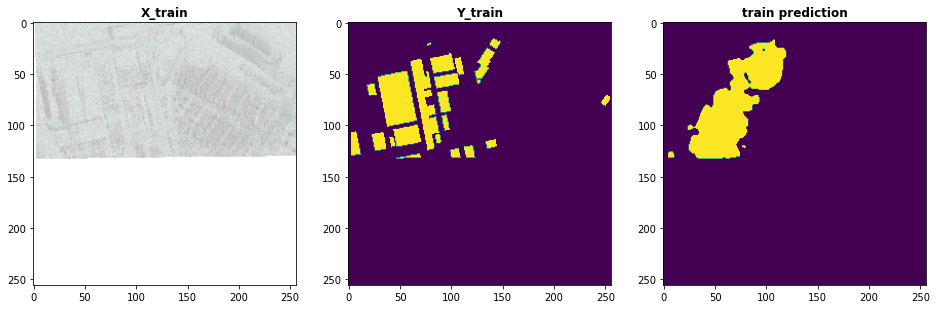

index: 17
val preds  set


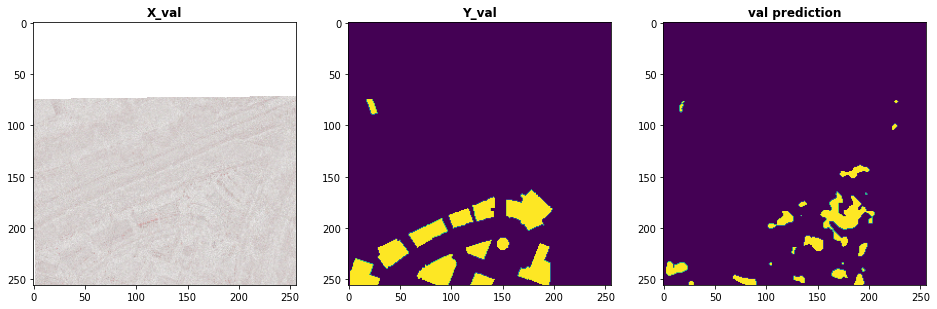

index: 2
test preds  set


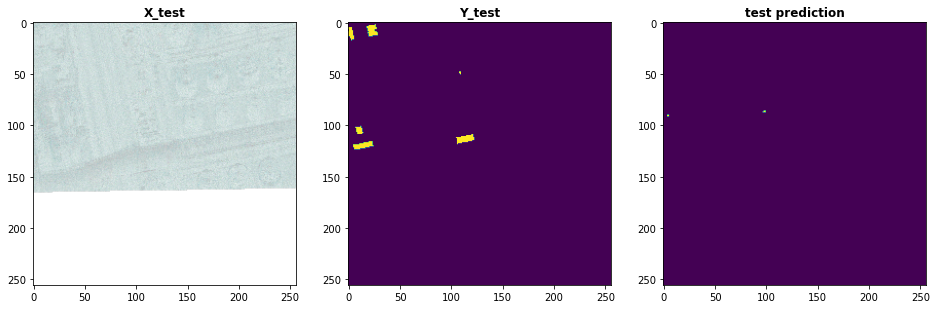

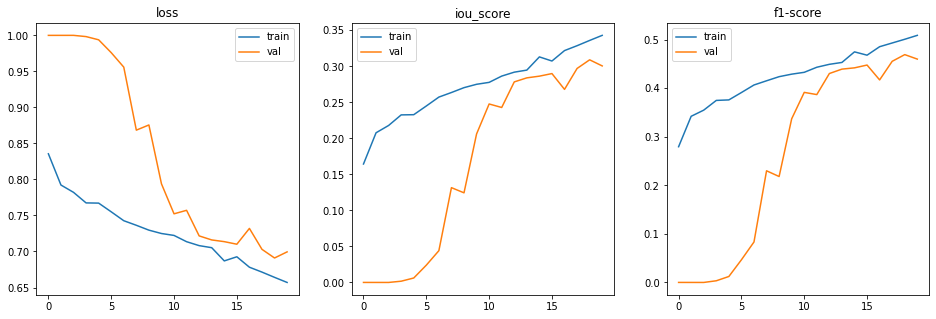

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

# PS-RGBNIR data

## Bring in actual ps rgbnir data

If the sample data is not generated, or we want to change something 

In [ ]:
# ''' run when changing parameters '''
# IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE

# PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)
# gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH)
# X_train_psrgbnir, Y_train_psrgbnir, X_test_psrgbnir, Y_test_psrgbnir = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX)

In [ ]:
# IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
# X_train = X_train_psrgbnir
# Y_train = Y_train_psrgbnir
# X_test = X_test_psrgbnir
# Y_test = Y_test_psrgbnir

If the sample data has already been generated and we want to just test with it 

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

### pretrain efficientnetb0, PS-RGBNIR only, loss: jaccardLoss


In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 40

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4))

model.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

model.save(PATH_DATA/(MODEL_NAME+'.h5'))
model.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Train on 720 samples, validate on 80 samples
Epoch 1/40
720/720 [==============================] - 34s 47ms/step - loss: 0.7958 - iou_score: 0.2042 - f1-score: 0.3336 - val_loss: 0.9093 - val_iou_score: 0.0907 - val_f1-score: 0.1661
Epoch 2/40
720/720 [==============================] - 16s 22ms/step - loss: 0.6233 - iou_score: 0.3767 - f1-score: 0.5440 - val_loss: 0.8749 - val_iou_score: 0.1251 - val_f1-score: 0.2219
Epoch 3/40
720/720 [==============================] - 16s 22ms/step - loss: 0.5388 - iou_score: 0.4612 - f1-score: 0.6301 - val_loss: 0.9915 - val_iou_score: 0.0085 - val_f1-score: 0.0167
Epoch 4/40
720/720 [==============================] - 16s 22ms/step - loss: 0.5048 - iou_score: 0.4952 - f1-score: 0.6614 - val_loss: 0.9501 - val_iou_score: 0.0499 - val_f1-score: 0.0943
Epoch 5/40
720/720 [==============================] - 16s 22ms/step - loss: 0.4753 - iou_score: 0.5247 - f1-score: 0.6873 - val_loss: 0.9118 - val_iou_score: 0.0882 - val_f1-score: 0.1605
Epoch 6/40
720/

In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 0s 5ms/step
train set evaluation
720/720 [==============================] - 4s 5ms/step
loss :  0.2912485811445448
iou_score :  0.7095420956611633
f1-score :  0.8298960328102112

validation set evaluation
80/80 [==============================] - 1s 7ms/step
loss :  0.7909529209136963
iou_score :  0.21797294914722443
f1-score :  0.35508260130882263

test set evaluation
80/80 [==============================] - 0s 5ms/step
loss :  0.38961224555969237
iou_score :  0.612127959728241
f1-score :  0.759141743183136
saved model metrics


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 592
train preds  set


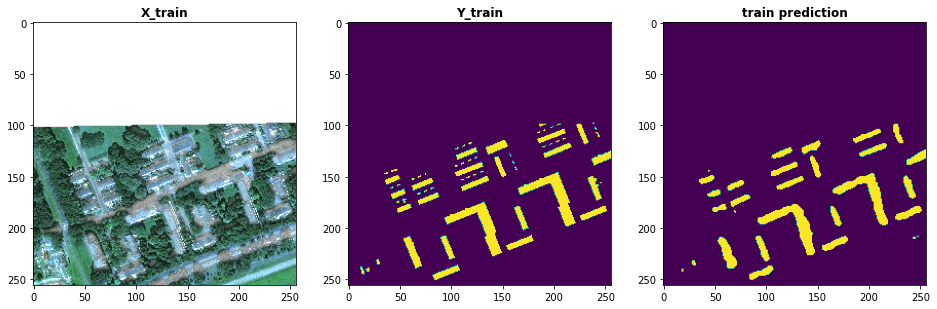

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 43
val preds  set


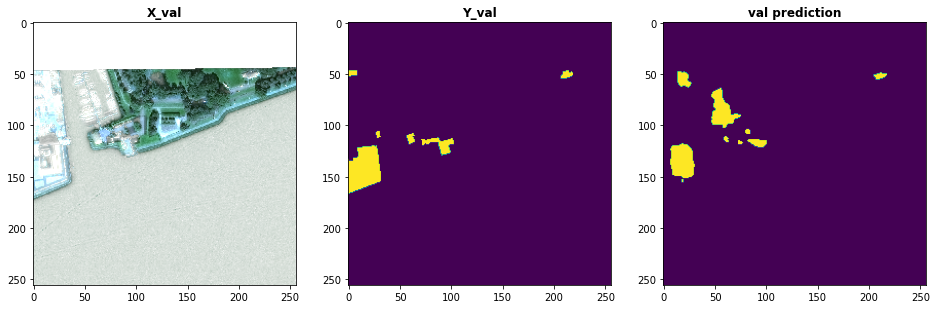

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 48
test preds  set


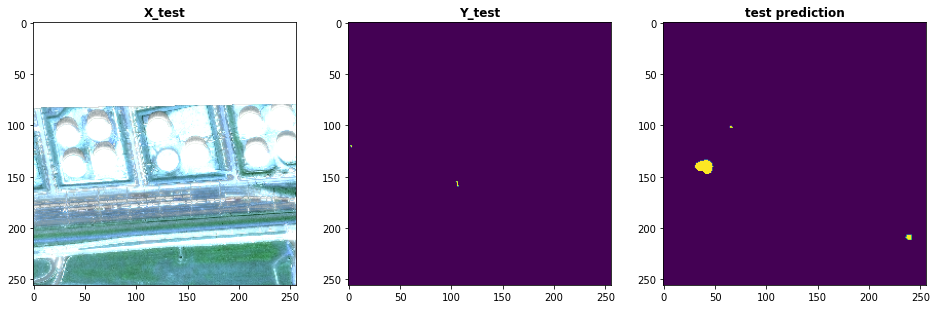

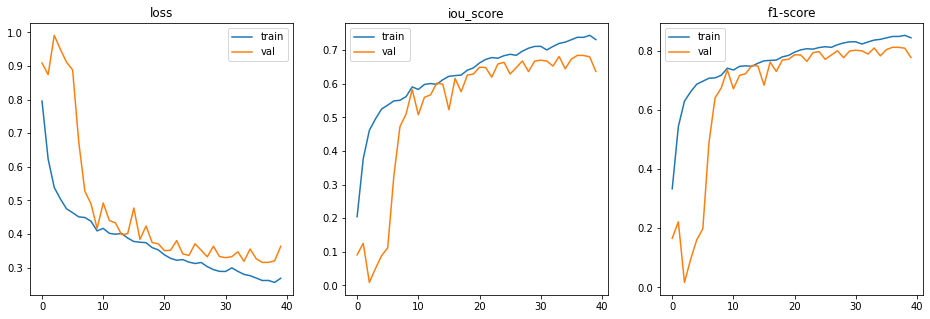

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

## Reconstruct

When reconstructing the model, we do all the same steps up until model.fit 

Before running model.fit, we load in the weights from a saved .h5 file 

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((800,256,256,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((800,256,256,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((80,256,256,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((80,256,256,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 20

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'vgg16'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model = Unet(backbone_name='vgg16', encoder_weights=None, input_shape=(None, None, 4))

model.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

model.load_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

# results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

# model.save(PATH_DATA/(MODEL_NAME+'.h5'))
# model.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 0s 6ms/step
train set evaluation
720/720 [==============================] - 4s 6ms/step
loss :  0.37568847205903794
iou_score :  0.6244261860847473
f1-score :  0.7685120701789856

validation set evaluation
80/80 [==============================] - 0s 6ms/step
loss :  0.80377699136734
iou_score :  0.20437248051166534
f1-score :  0.3369899094104767

test set evaluation
80/80 [==============================] - 0s 6ms/step
loss :  0.4028365254402161
iou_score :  0.5952656269073486
f1-score :  0.7461951375007629
saved model metrics


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 464
train preds  set


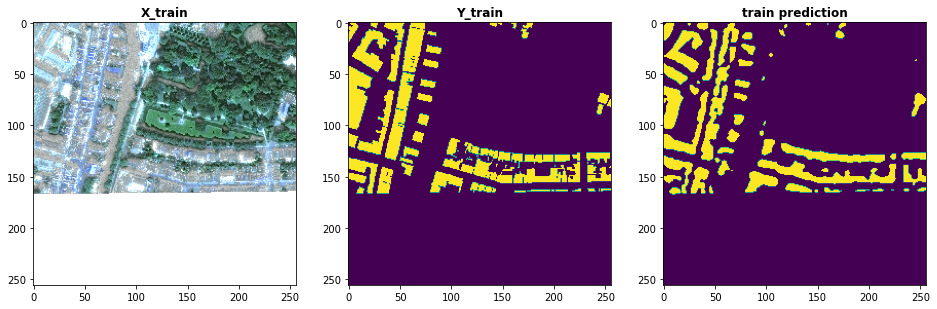

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 58
val preds  set


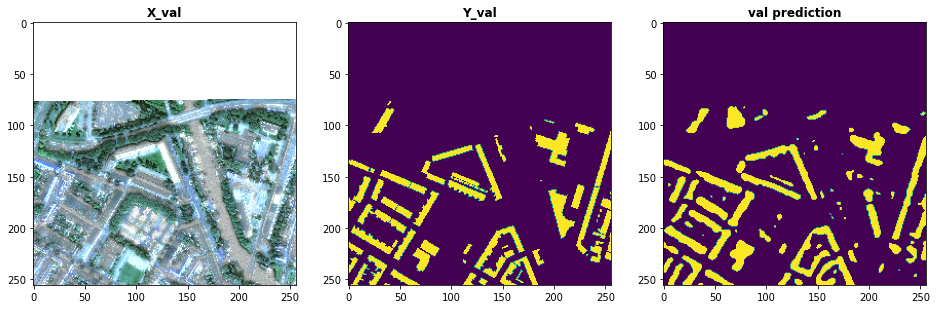

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 60
test preds  set


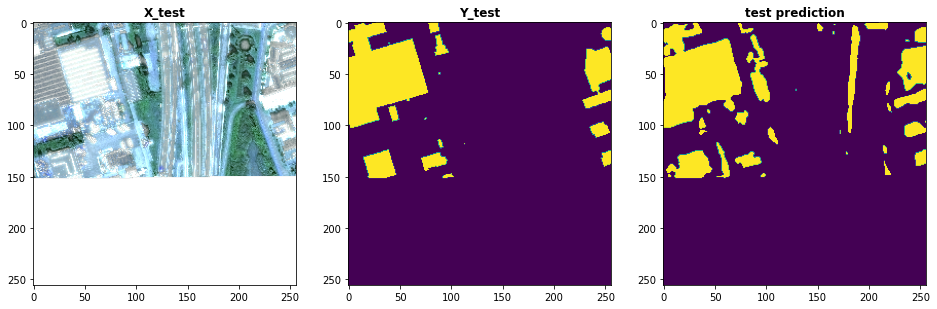

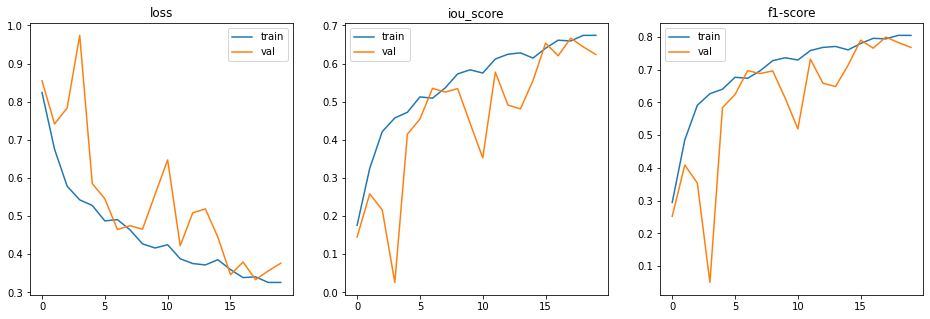

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

# Transfer learning (didn't adjust trainable layers)

We shall try learning on the PS-RGBNIR first by loading in the weights, then passing the weights to the SAR data and see how that works

## Reconstruct PS-RGBNIR

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 40

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model_transfer_psrgbnir = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4), encoder_freeze=True)

model_transfer_psrgbnir.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

model_transfer_psrgbnir.load_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

# results = model_transfer_psrgbnir.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

# model_transfer_psrgbnir.save(PATH_DATA/(MODEL_NAME+'.h5'))
# model_transfer_psrgbnir.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model_transfer_psrgbnir, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 1s 11ms/step
train set evaluation
720/720 [==============================] - 10s 13ms/step
loss :  0.2912485784954495
iou_score :  0.7095420956611633
f1-score :  0.829896092414856

validation set evaluation
80/80 [==============================] - 1s 12ms/step
loss :  0.7909529566764831
iou_score :  0.21797293424606323
f1-score :  0.35508260130882263

test set evaluation
80/80 [==============================] - 1s 11ms/step
loss :  0.3896122694015503
iou_score :  0.612127959728241
f1-score :  0.759141743183136
saved model metrics


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 647
train preds  set


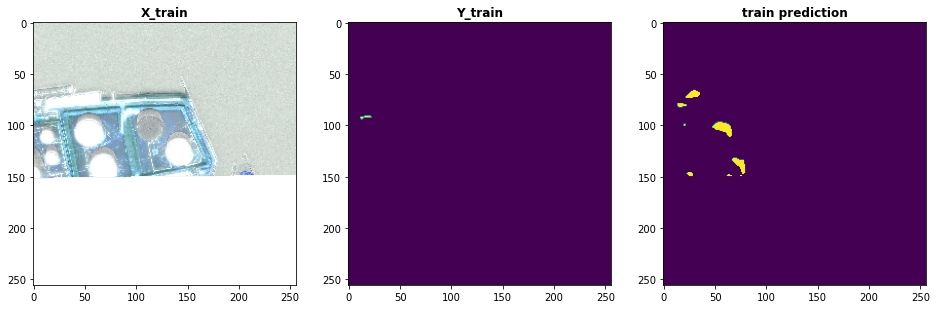

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 25
val preds  set


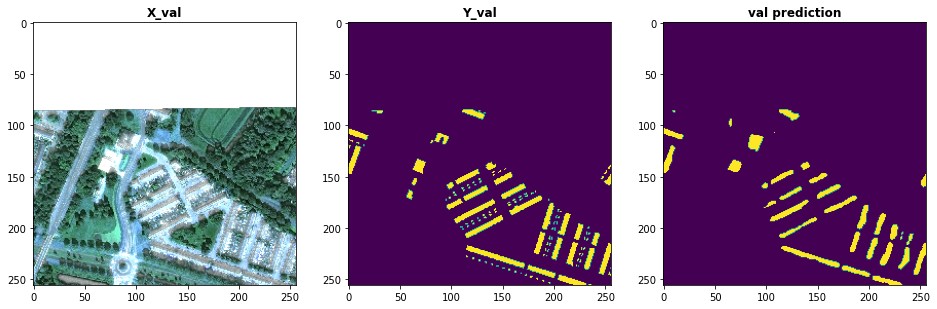

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 52
test preds  set


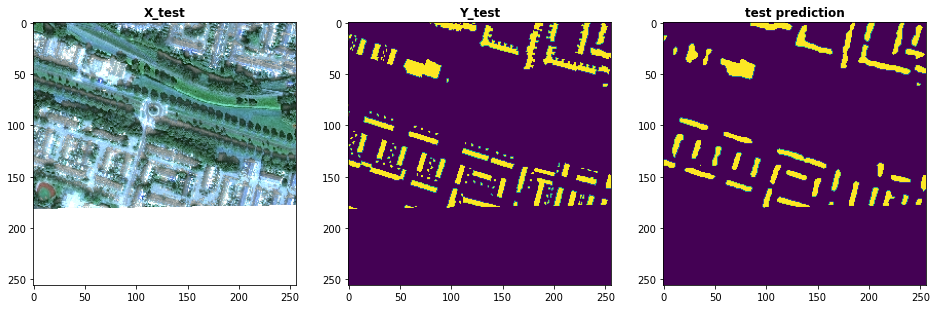

NameError: ignored

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

## Reconstruct SAR, but set for transfer learning

We utilise the previous model that was trained on PSRGBNIR images and try and transfer the model weights into the SAR model

Both models are trained on efficientnetb0, it is far easier to transfer weights using the same backbone versus using different ones. But experimentation can be done to try and mix models - PSRGBNIR performs better on the vgg16 backbone

In [ ]:
''' Assumes we already have a sample data generated, else need to create the np arrays and save  '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 20

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model_transfer_sar = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4), encoder_freeze=True)

model_transfer_sar.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

PSRGBNIR_WEIGHTS = '/content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/PS-RGBNIR_256x256/MODEL_segmentation-models Unet__PRETRAIN_efficientnetb0__LOSS_JaccardLoss__SHAPE_PS-RGBNIR_256x256__EPOCH_40__TRAIN_800__TEST_80_WEIGHTS.h5'
model_transfer_sar.load_weights(PSRGBNIR_WEIGHTS)

# results = model_transfer_sar.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

# model_transfer_sar.save(PATH_DATA/(MODEL_NAME+'.h5'))
# model_transfer_sar.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))



/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
results = model_transfer_sar.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

Train on 720 samples, validate on 80 samples
Epoch 1/20
720/720 [==============================] - 45s 63ms/step - loss: 0.8356 - iou_score: 0.1644 - f1-score: 0.2795 - val_loss: 1.0000 - val_iou_score: 3.6634e-05 - val_f1-score: 7.3264e-05
Epoch 2/20
720/720 [==============================] - 31s 43ms/step - loss: 0.7923 - iou_score: 0.2077 - f1-score: 0.3422 - val_loss: 1.0000 - val_iou_score: 2.0542e-05 - val_f1-score: 4.1083e-05
Epoch 3/20
720/720 [==============================] - 31s 43ms/step - loss: 0.7821 - iou_score: 0.2179 - f1-score: 0.3549 - val_loss: 1.0000 - val_iou_score: 1.0225e-05 - val_f1-score: 2.0450e-05
Epoch 4/20
720/720 [==============================] - 31s 43ms/step - loss: 0.7674 - iou_score: 0.2326 - f1-score: 0.3749 - val_loss: 0.9983 - val_iou_score: 0.0017 - val_f1-score: 0.0035
Epoch 5/20
720/720 [==============================] - 31s 43ms/step - loss: 0.7672 - iou_score: 0.2328 - f1-score: 0.3759 - val_loss: 0.9938 - val_iou_score: 0.0062 - val_f1-score

In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model_transfer_sar, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 1s 11ms/step
train set evaluation
720/720 [==============================] - 8s 11ms/step
loss :  0.6528417587280273
iou_score :  0.349097341299057
f1-score :  0.515781044960022

validation set evaluation
80/80 [==============================] - 1s 12ms/step
loss :  0.7838993668556213
iou_score :  0.21916508674621582
f1-score :  0.35735735297203064

test set evaluation
80/80 [==============================] - 1s 11ms/step
loss :  0.7351592540740967
iou_score :  0.26315605640411377
f1-score :  0.4161384105682373
saved model metrics


index: 321
train preds  set


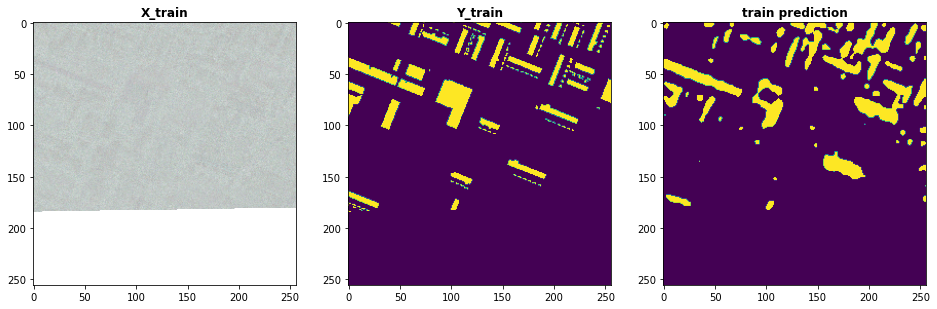

index: 26
val preds  set


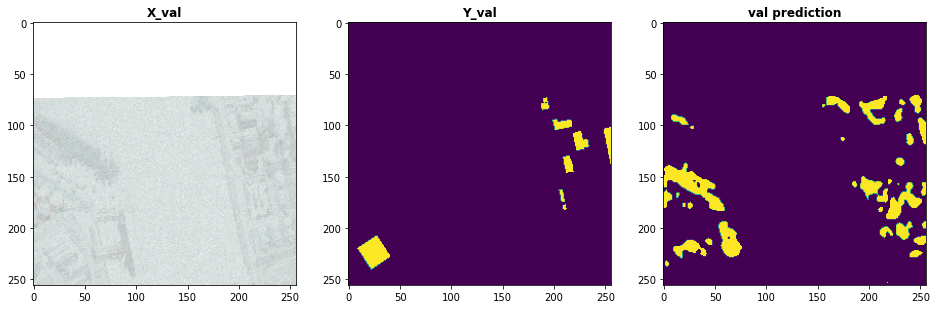

index: 27
test preds  set


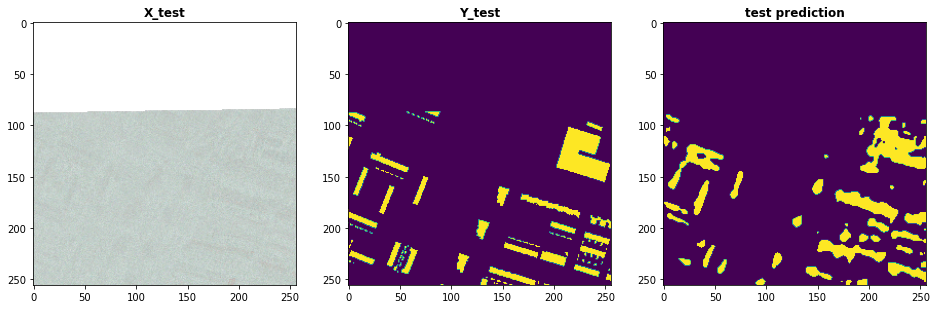

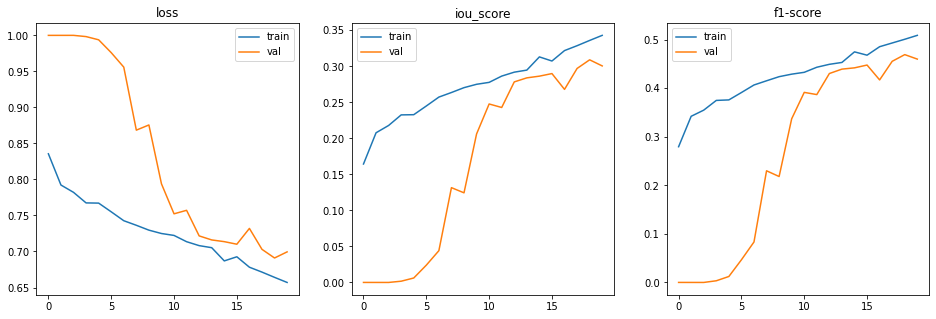

In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

In [ ]:
model_transfer_sar.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 4 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 1152        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

## pretrain efficientnetb0, SAR only, loss: jaccardLoss: 60 epochs comparison


In [ ]:
''' Assumes we already have a sample data generated, else need to create the np arrays and save  '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 60

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4))

model.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

model.save(PATH_DATA/(MODEL_NAME+'.h5'))
model.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Train on 720 samples, validate on 80 samples
Epoch 1/60
720/720 [==============================] - 35s 49ms/step - loss: 0.8703 - iou_score: 0.1297 - f1-score: 0.2276 - val_loss: 0.9463 - val_iou_score: 0.0537 - val_f1-score: 0.1011
Epoch 2/60
720/720 [==============================] - 16s 22ms/step - loss: 0.8006 - iou_score: 0.1994 - f1-score: 0.3301 - val_loss: 0.9551 - val_iou_score: 0.0449 - val_f1-score: 0.0859
Epoch 3/60
720/720 [==============================] - 16s 22ms/step - loss: 0.7682 - iou_score: 0.2318 - f1-score: 0.3741 - val_loss: 0.9859 - val_iou_score: 0.0141 - val_f1-score: 0.0278
Epoch 4/60
720/720 [==============================] - 16s 22ms/step - loss: 0.7499 - iou_score: 0.2501 - f1-score: 0.3990 - val_loss: 0.9924 - val_iou_score: 0.0076 - val_f1-score: 0.0151
Epoch 5/60
720/720 [==============================] - 16s 22ms/step - loss: 0.7426 - iou_score: 0.2574 - f1-score: 0.4066 - val_loss: 0.9365 - val_iou_score: 0.0635 - val_f1-score: 0.1185
Epoch 6/60
720/

In [ ]:
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

80/80 [==============================] - 0s 5ms/step
train set evaluation
720/720 [==============================] - 4s 5ms/step
loss :  0.3925217747688293
iou_score :  0.6088109016418457
f1-score :  0.7560808062553406

validation set evaluation
80/80 [==============================] - 0s 6ms/step
loss :  0.8489769101142883
iou_score :  0.15595977008342743
f1-score :  0.26871857047080994

test set evaluation
80/80 [==============================] - 0s 5ms/step
loss :  0.6452317357063293
iou_score :  0.35261741280555725
f1-score :  0.5210618376731873
saved model metrics


In [ ]:
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
plot_history(results.history)

# TRIAL

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)

X_train_sample_fname = 'sample_{}_{}x{}_X_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/X_train_sample_fname, X_train.ravel())
X_train_sample = np.load(PATH_DATA/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,4))

Y_train_sample_fname = 'sample_{}_{}x{}_Y_train_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TRAIN)
# np.save(PATH_DATA/Y_train_sample_fname, Y_train.ravel())
Y_train_sample = np.load(PATH_DATA/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))

X_test_sample_fname = 'sample_{}_{}x{}_X_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/X_test_sample_fname, X_test.ravel())
X_test_sample = np.load(PATH_DATA/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,4))

Y_test_sample_fname = 'sample_{}_{}x{}_Y_test_{}.npy'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, SIZE_TEST)
# np.save(PATH_DATA/Y_test_sample_fname, Y_test.ravel())
Y_test_sample = np.load(PATH_DATA/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE
X_train = X_train_sample
Y_train = Y_train_sample
X_test = X_test_sample
Y_test = Y_test_sample

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = JaccardLoss()
MODEL_METRICS =[IOUScore(), FScore()]
MODEL_VAL_SPLIT = 0.1
MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 40

MODEL_TYPE = 'segmentation-models Unet'
MODEL_PRETRAIN = 'efficientnetb0'
MODEL_LOSS_FUNCTION = 'JaccardLoss'

MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__SHAPE_{}_{}x{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

In [ ]:
model_transfer_psrgbnir = Unet(backbone_name='efficientnetb0', encoder_weights=None, input_shape=(None, None, 4), encoder_freeze=True)

model_transfer_psrgbnir.compile(
    optimizer=MODEL_OPTIMIZER,
    loss=MODEL_LOSS,
    metrics=MODEL_METRICS,
)

checkpointer = tf.keras.callbacks.ModelCheckpoint( (MODEL_NAME + '.h5'), verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]   

model_transfer_psrgbnir.load_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

# results = model_transfer_psrgbnir.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT)

# model_transfer_psrgbnir.save(PATH_DATA/(MODEL_NAME+'.h5'))
# model_transfer_psrgbnir.save_weights(PATH_DATA/(MODEL_NAME+'_WEIGHTS.h5'))

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
root_dir

'/content/gdrive/My Drive/Colab Notebooks'

In [ ]:
DATA = Path(root_dir + '/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity')

In [ ]:
fnames = next(os.walk(DATA))[2]

In [ ]:
fnames[:3]

['SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804113009_20190804113242_tile_4800.tif',
 'SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822101929_20190822102224_tile_10381.tif',
 'SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822160239_20190822160529_tile_3879.tif']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2828: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(array([5.7726192e+07, 1.0542140e+06, 4.0176090e+06, 7.6181370e+06,
        1.1377335e+07, 1.6795838e+07, 1.8919798e+07, 1.6336887e+07,
        1.3308603e+07, 8.8251770e+06, 4.2543890e+06, 1.4760360e+06,
        2.4093200e+05, 3.3194000e+04, 1.1540000e+04, 3.0220000e+03,
        8.0200000e+02, 2.0400000e+02, 7.3000000e+01, 1.8000000e+01]),
 array([ 0.       ,  4.4967937,  8.9935875, 13.490381 , 17.987175 ,
        22.483969 , 26.980762 , 31.477556 , 35.97435  , 40.471146 ,
        44.967937 , 49.46473  , 53.961525 , 58.45832  , 62.955112 ,
        67.451904 , 71.9487   , 76.445496 , 80.94229  , 85.43908  ,
        89.935875 ], dtype=float32),
 <a list of 20 Patch objects>)

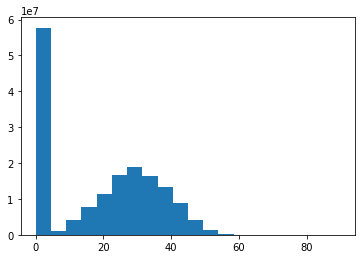

In [ ]:
def read(id):
  img = rasterio.open(DATA/id).read()
  return img
plt.hist(np.stack(map(read, fnames[:50])).flatten(), 20)
